In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout, Reshape
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [3]:
train_dir='/content/drive/MyDrive/Colab Notebooks/Android-App-Skin-Cancer-Detector/Training/Dataset'

In [4]:
Labels = ['Benign', 'Malignant']

In [5]:
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i]) 

class : 
0 Benign
1 Malignant


In [6]:
print('Number of classes:',len(Labels))

Number of classes: 2


In [7]:
module_selection = ("efficientnetv2-l", 480,480) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

In [8]:
IMAGE_SIZE

(480, 480)

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      vertical_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 24 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [10]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE]  )

In [11]:
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [12]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.BatchNormalization(),
    Reshape((1, 1, 1280)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              117746848 
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 1, 1, 1280)        0         
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                      

In [13]:
# Create a learning rate and early_stopping callbacks
# Create a learning rate callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)



In [14]:
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), 
   loss='BinaryCrossentropy',
   metrics=['BinaryAccuracy'])


In [15]:
EPOCHS=50
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        callbacks=[early_stopping,learning_rate_callback],
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/50
1/1 [==============================] - 62s 62s/step - loss: 0.8077 - binary_accuracy: 0.4375 - val_loss: 0.6197 - val_binary_accuracy: 0.7500 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.1365 - binary_accuracy: 1.0000 - val_loss: 0.5361 - val_binary_accuracy: 0.8750 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.1813 - binary_accuracy: 0.9375 - val_loss: 0.4850 - val_binary_accuracy: 0.9375 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 4s 4s/step - loss: 0.0801 - binary_accuracy: 0.9375 - val_loss: 0.4442 - val_binary_accuracy: 1.0000 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 0.0380 - binary_accuracy: 1.0000 - val_loss: 0.4223 - val_binary_accuracy: 0.9375 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - 3s 3s/step - loss: 0.0459 - binary_accuracy: 1.0000 - val_loss: 0.4213 - val_binary_accuracy: 0.9375 - lr: 0.0010
Epoch 7/50
1/1

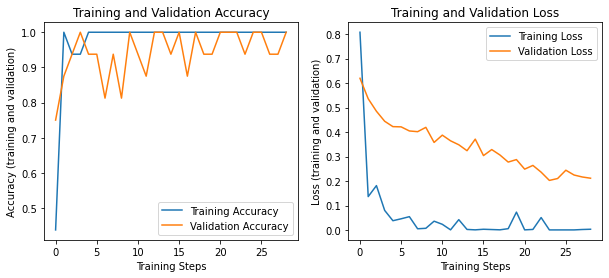

In [17]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(29)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

1/1 [==============================] - 5s 5s/step
class: Benign, confidence: 0.936729


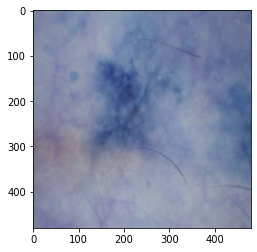

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 67ms/step
class: Benign, confidence: 0.993960


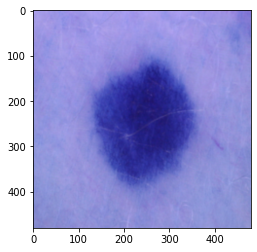

1/1 [==============================] - 0s 64ms/step
class: Benign, confidence: 0.990942


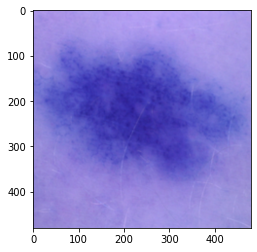

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 66ms/step
class: Benign, confidence: 0.965933


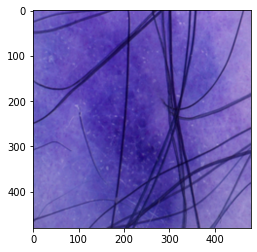

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 62ms/step
class: Benign, confidence: 0.801081


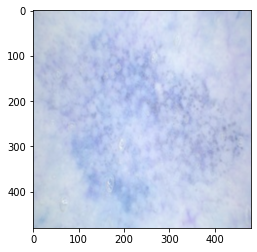

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 62ms/step
class: Malignant, confidence: 0.804465


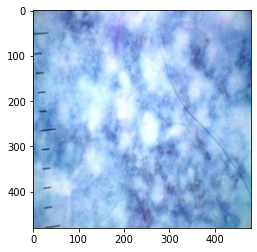

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 65ms/step
class: Benign, confidence: 0.827335


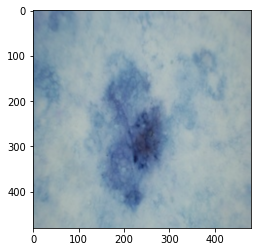

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 62ms/step
class: Benign, confidence: 0.656388


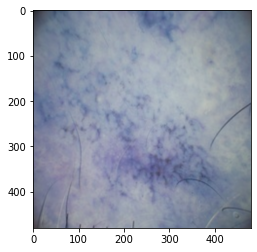

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 69ms/step
class: Benign, confidence: 0.672344


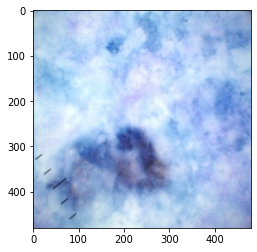

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 80ms/step
class: Benign, confidence: 0.793863


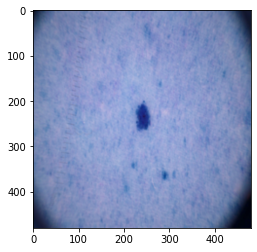

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 73ms/step
class: Benign, confidence: 0.820678


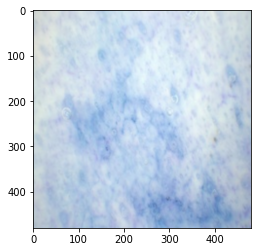

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 94ms/step
class: Benign, confidence: 0.979893


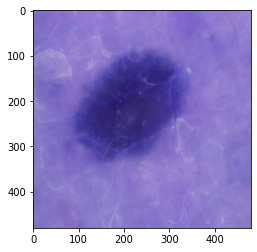

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 105ms/step
class: Benign, confidence: 0.982450


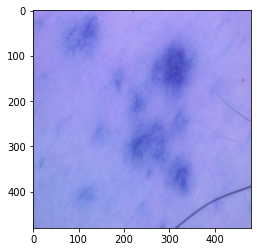

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 88ms/step
class: Malignant, confidence: 0.724585


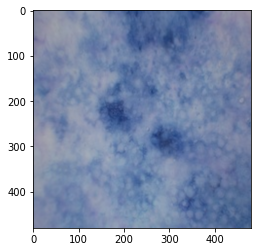

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 114ms/step
class: Benign, confidence: 0.889723


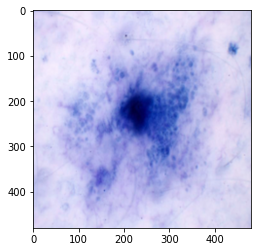

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 100ms/step
class: Benign, confidence: 0.925257


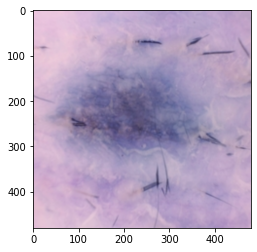

<Figure size 432x288 with 0 Axes>

In [18]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (480, 480) )
    img = img /255
    
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    
    return {Labels[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    
    
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

1/1 [==============================] - 5s 5s/step
Classification Report
              precision    recall  f1-score   support

      benign       0.88      0.88      0.88         8
   malignant       0.88      0.88      0.88         8

    accuracy                           0.88        16
   macro avg       0.88      0.88      0.88        16
weighted avg       0.88      0.88      0.88        16

1/1 [==============================] - 2s 2s/step - loss: 0.2705 - binary_accuracy: 0.9375
[0.2705259919166565, 0.9375]


Confusion Matrix


<AxesSubplot:>

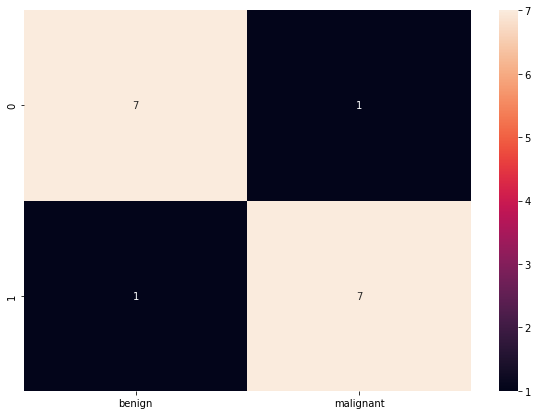

In [20]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

In [21]:
do_fine_tuning = True 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [22]:
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0001), 
   loss='BinaryCrossentropy',
   metrics=['BinaryAccuracy'])


In [24]:
EPOCHS=3
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        callbacks=[early_stopping,learning_rate_callback],
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/3


ResourceExhaustedError: ignored

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

#Export as saved model and convert to TFLite

In [ ]:
import time
t = time.time()

export_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)

export_path

In [ ]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {Labels[class_idx]: probabilities[class_idx]}

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)